1.  Introduction
    1. My Goal
    2. Reference
2.  Data Understanding
    1. Data check
    2. Find Null data
    3. Feature analysis
    4. Predict null data based on statistical method
    5. One hot encoding
3. Prediction with xgboost
    1. Using stratified shuffle split
4. Things to do

# 1. Introduction
- In this competition, we need to predict insurance claim. 
- This competition contains classification problem.
- Metric is gini-coefficient.

### 1.1 My Goal
- In this competition, I'm going to write my first kernel.
- And I wish my kernel will help someone who is beginner like me!
- If I can, I want to get a high rank.

## 1.1.1  Reference
- I used a few feature extraction ideas from [Keui Shen Nong's work](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/kernels?sortBy=votes&group=everyone&pageSize=20&language=all&outputType=all&competitionId=7082&startRow=0). His work is nice!!
- [Anokas's work](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/kernels?sortBy=votes&group=everyone&pageSize=20&language=all&outputType=all&competitionId=7082&startRow=0) made me to start this competition! He is fast!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns # visualization
import missingno as msno

import xgboost as xgb # Gradient Boosting
import warnings
sns.set(style='white', context='notebook', palette='deep')

# warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output

# 2. Data understanding

In [2]:
np.random.seed(1989)
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("Train shape : ", train.shape)
print("Test shape : ", test.shape )

Train shape :  (595212, 59)
Test shape :  (892816, 58)


In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [5]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892816 non-null int64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892816 non-null int64
ps_ind_05_cat     892816 non-null int64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         892816 non-null float64
ps_

### My thought for data understanding 
As you can see, the number of feature is 57. But, the name of each feature don't say what the feature exactly means. So we really need to stand on the computational and statistical method.

In [6]:
targets = train['target'].values

(0.0, 700000)

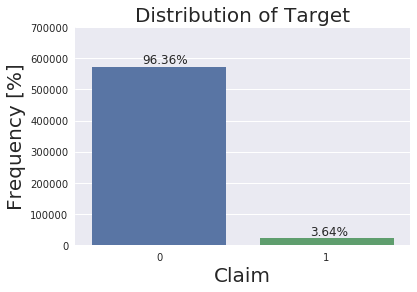

In [7]:
sns.set(style="darkgrid")
ax = sns.countplot(x = targets)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))
plt.title('Distribution of Target', fontsize=20)
plt.xlabel('Claim', fontsize=20)
plt.ylabel('Frequency [%]', fontsize=20)
ax.set_ylim(top=700000)

As you can see, the class 1 of claim is very smaller than 0. So, If we simply split the train and test during training,
this ununiform distribution could cause biased model. This must be treated cautiously and could be solved by more reasonable sampling! In this kernel, I will use staratified Kfold method. I reffered to [HyungsukKang work!
](https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-with-analysis-0-281)

## 2.1 Data check
- This coding style was from beluga's work. I respect him.
- In this section, we check whether tha data between train and test are unique or overlapped.
- and see if there are some missing values.

In [8]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('Oh no')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('Oh no')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('Oh no')

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.


In 'Data description', we can see below sentences.
> Values of -1 indicate that the feature was missing from the observation.

So, we need to find null value by finding '-1' value.

## 2.2 Find Null data
We need to find some features containing null data.<br>
reference: [Anisotropic's work](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial)

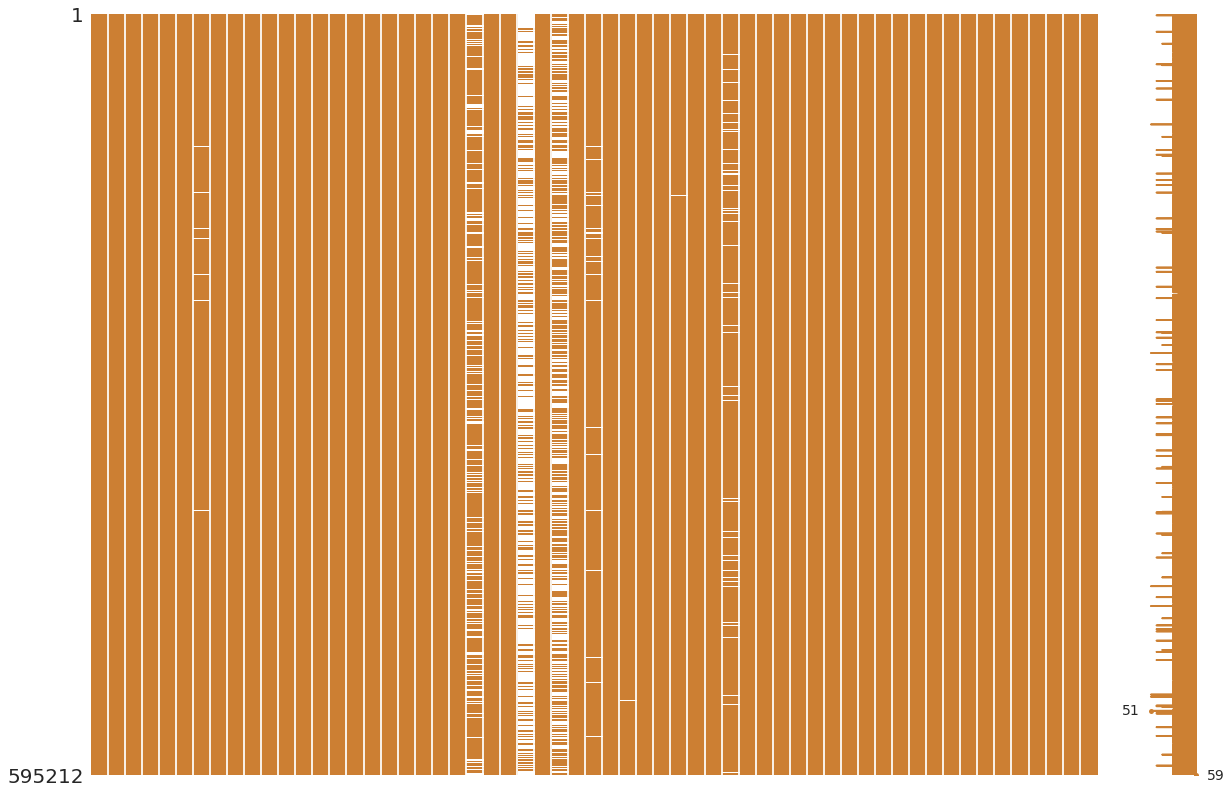

In [9]:
import missingno as msno

train_null = train
train_null = train_null.replace(-1, np.NaN)

msno.matrix(df=train_null.iloc[:, :], figsize=(20, 14), color=(0.8, 0.5, 0.2))   

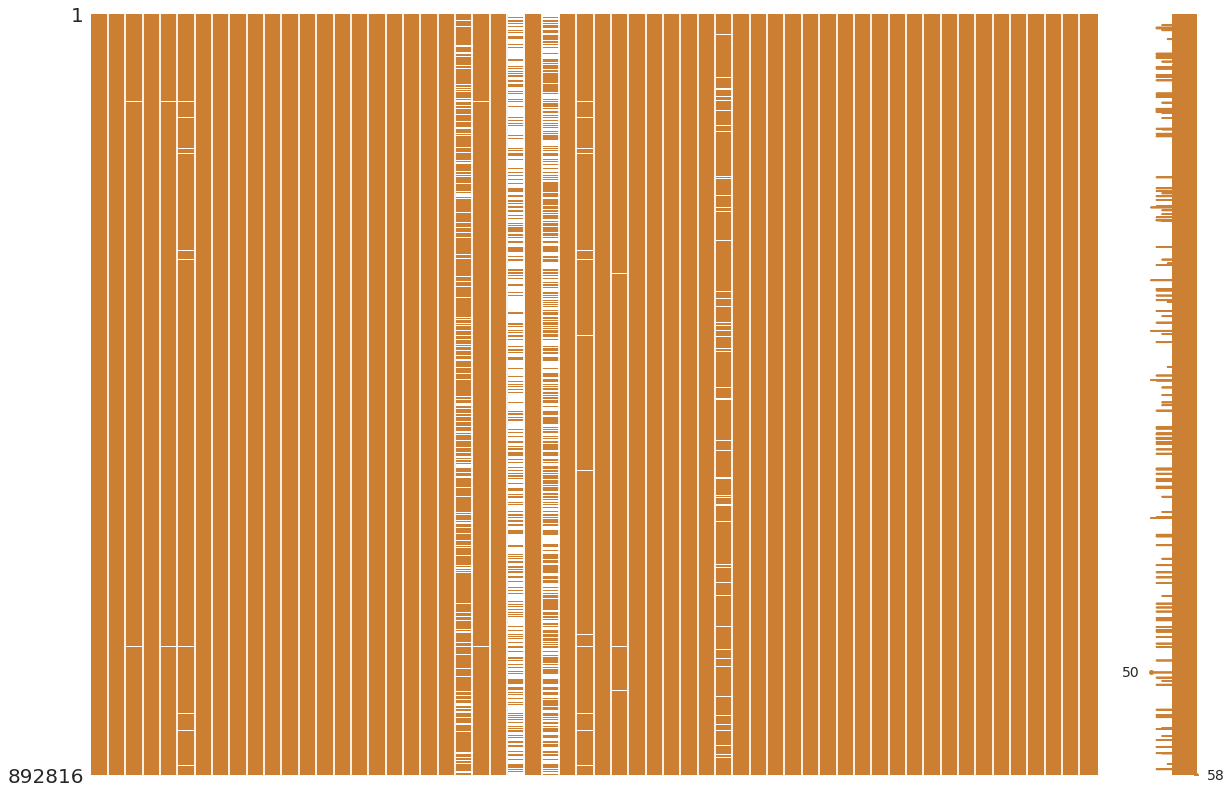

In [10]:
test_null = test
test_null = test_null.replace(-1, np.NaN)

msno.matrix(df=test_null.iloc[:, :], figsize=(20, 14), color=(0.8, 0.5, 0.2))   

In [11]:
# Extract columns with null data
train_null = train_null.loc[:, train_null.isnull().any()]
test_null = test_null.loc[:, test_null.isnull().any()]

print(train_null.columns)
print(test_null.columns)

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12',
       'ps_car_14'],
      dtype='object')
Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14'],
      dtype='object')


In [12]:
print('Columns \t Number of NaN')
for column in train_null.columns:
    print('{}:\t {}'.format(column,len(train_null[column][np.isnan(train_null[column])])))

Columns 	 Number of NaN
ps_ind_02_cat:	 216
ps_ind_04_cat:	 83
ps_ind_05_cat:	 5809
ps_reg_03:	 107772
ps_car_01_cat:	 107
ps_car_02_cat:	 5
ps_car_03_cat:	 411231
ps_car_05_cat:	 266551
ps_car_07_cat:	 11489
ps_car_09_cat:	 569
ps_car_11:	 5
ps_car_12:	 1
ps_car_14:	 42620


As you can see, Many NaN will bring the error on my prediction. So, before leanring and prediction, NaN values must be replaced with some reasonable values. 
To do that, analysis on feature it self is needed.

## 2.3 Feature analysis
As said in data description, there are many type of features denoted by using postfix such as bin, cat. So, we need to divide them into each parts, and analyze individually.

In [13]:
# divides all features in to 'bin', 'cat' and 'etc' group.

feature_list = list(train.columns)
def groupFeatures(features):
    features_bin = []
    features_cat = []
    features_etc = []
    for feature in features:
        if 'bin' in feature:
            features_bin.append(feature)
        elif 'cat' in feature:
            features_cat.append(feature)
        elif 'id' in feature or 'target' in feature:
            continue
        else:
            features_etc.append(feature)
    return features_bin, features_cat, features_etc

feature_list_bin, feature_list_cat, feature_list_etc = groupFeatures(feature_list)
print("# of binary feature : ", len(feature_list_bin))
print("# of categorical feature : ", len(feature_list_cat))
print("# of other feature : ", len(feature_list_etc))

# of binary feature :  17
# of categorical feature :  14
# of other feature :  26


To see the characteristics of each features, I plotted the histogram for each feature with their head values. This analysis helps us to do the preprocessing of data well.

In [14]:
def TrainTestHistogram(train, test, feature):
    fig, axes = plt.subplots(len(feature), 2, figsize=(10, 40))
    fig.tight_layout()

    left  = 0  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.3   # the amount of width reserved for blank space between subplots
    hspace = 0.7   # the amount of height reserved for white space between subplot

    plt.subplots_adjust(left=left, bottom=bottom, right=right, 
                        top=top, wspace=wspace, hspace=hspace)
    count = 0
    for i, ax in enumerate(axes.ravel()):
        if i % 2 == 0:
            title = 'Train: ' + feature[count]
            ax.hist(train[feature[count]], bins=30, normed=False)
            ax.set_title(title)
        else:
            title = 'Test: ' + feature[count]
            ax.hist(test[feature[count]], bins=30, normed=False)
            ax.set_title(title)
            count = count + 1

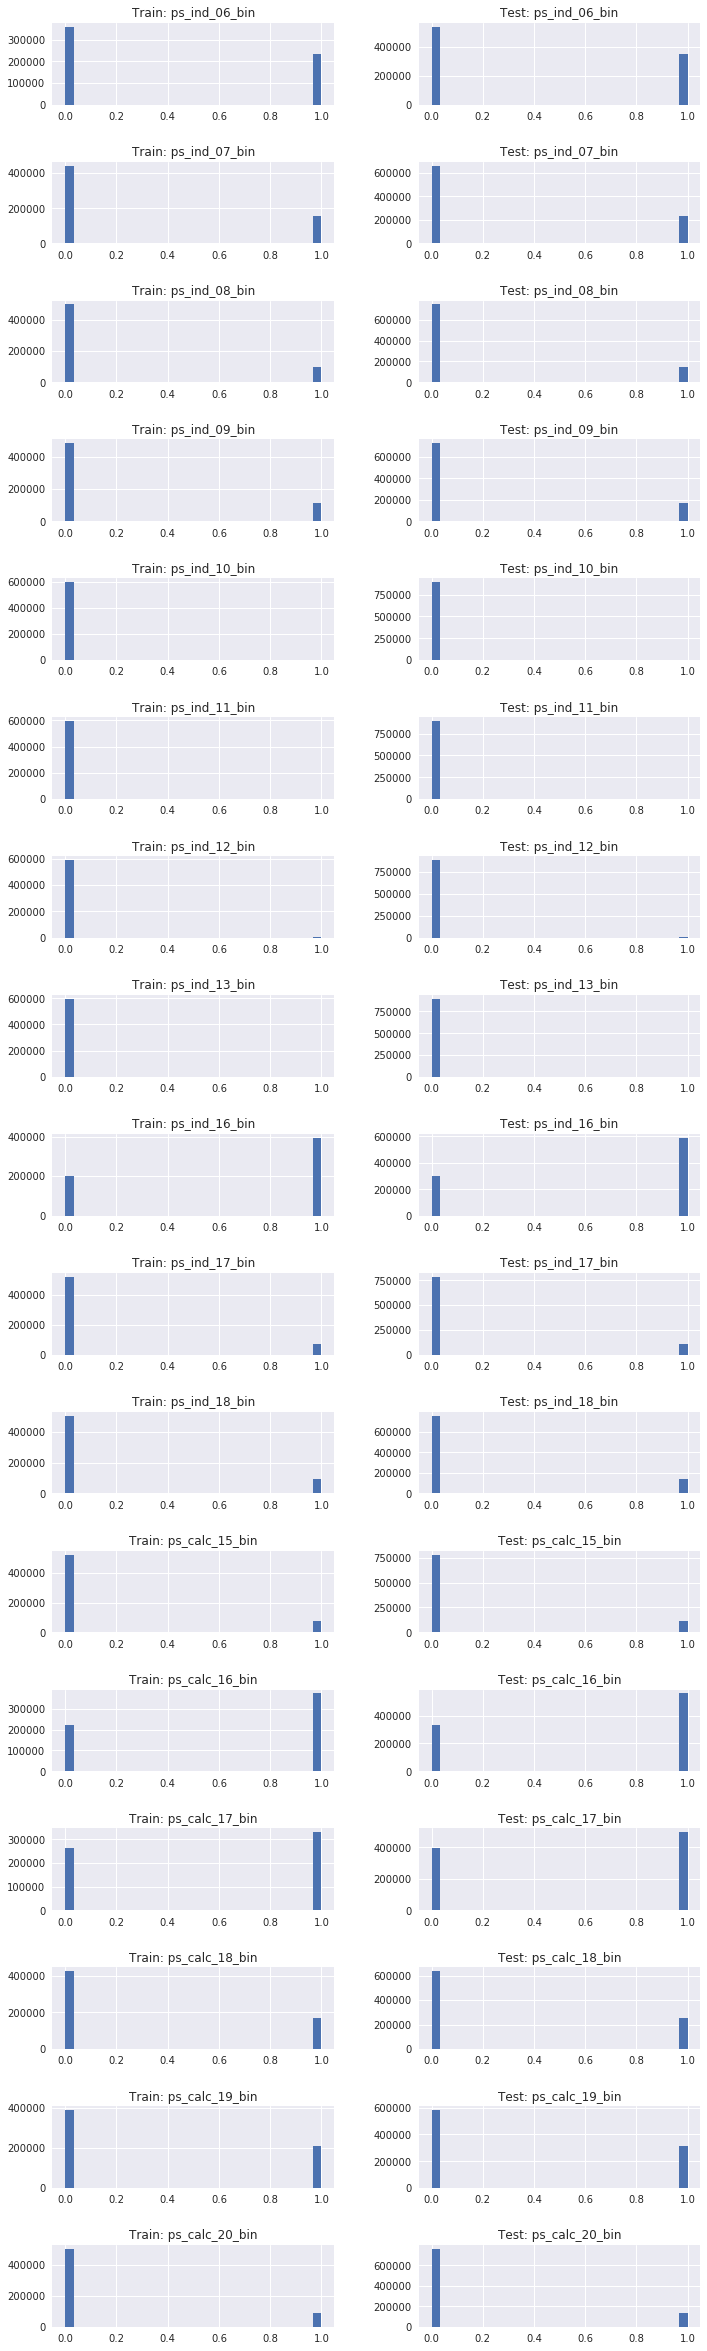

In [15]:
# For bin features
TrainTestHistogram(train, test, feature_list_bin)

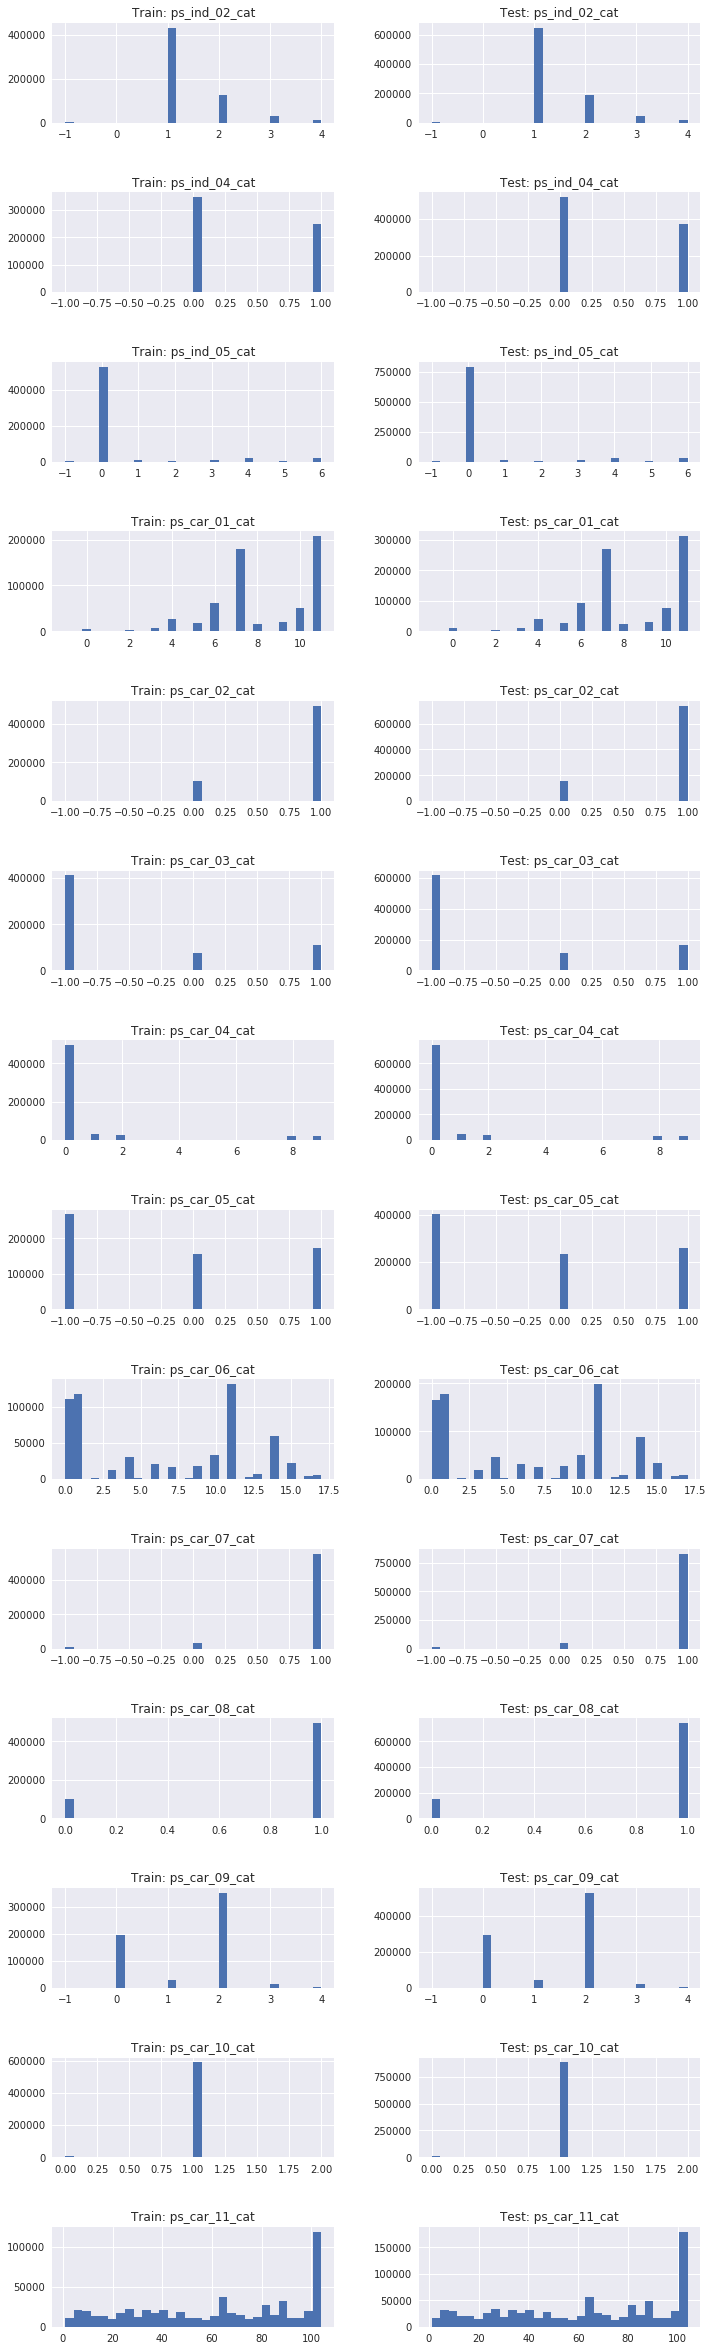

In [16]:
# For cat features
TrainTestHistogram(train, test, feature_list_cat)

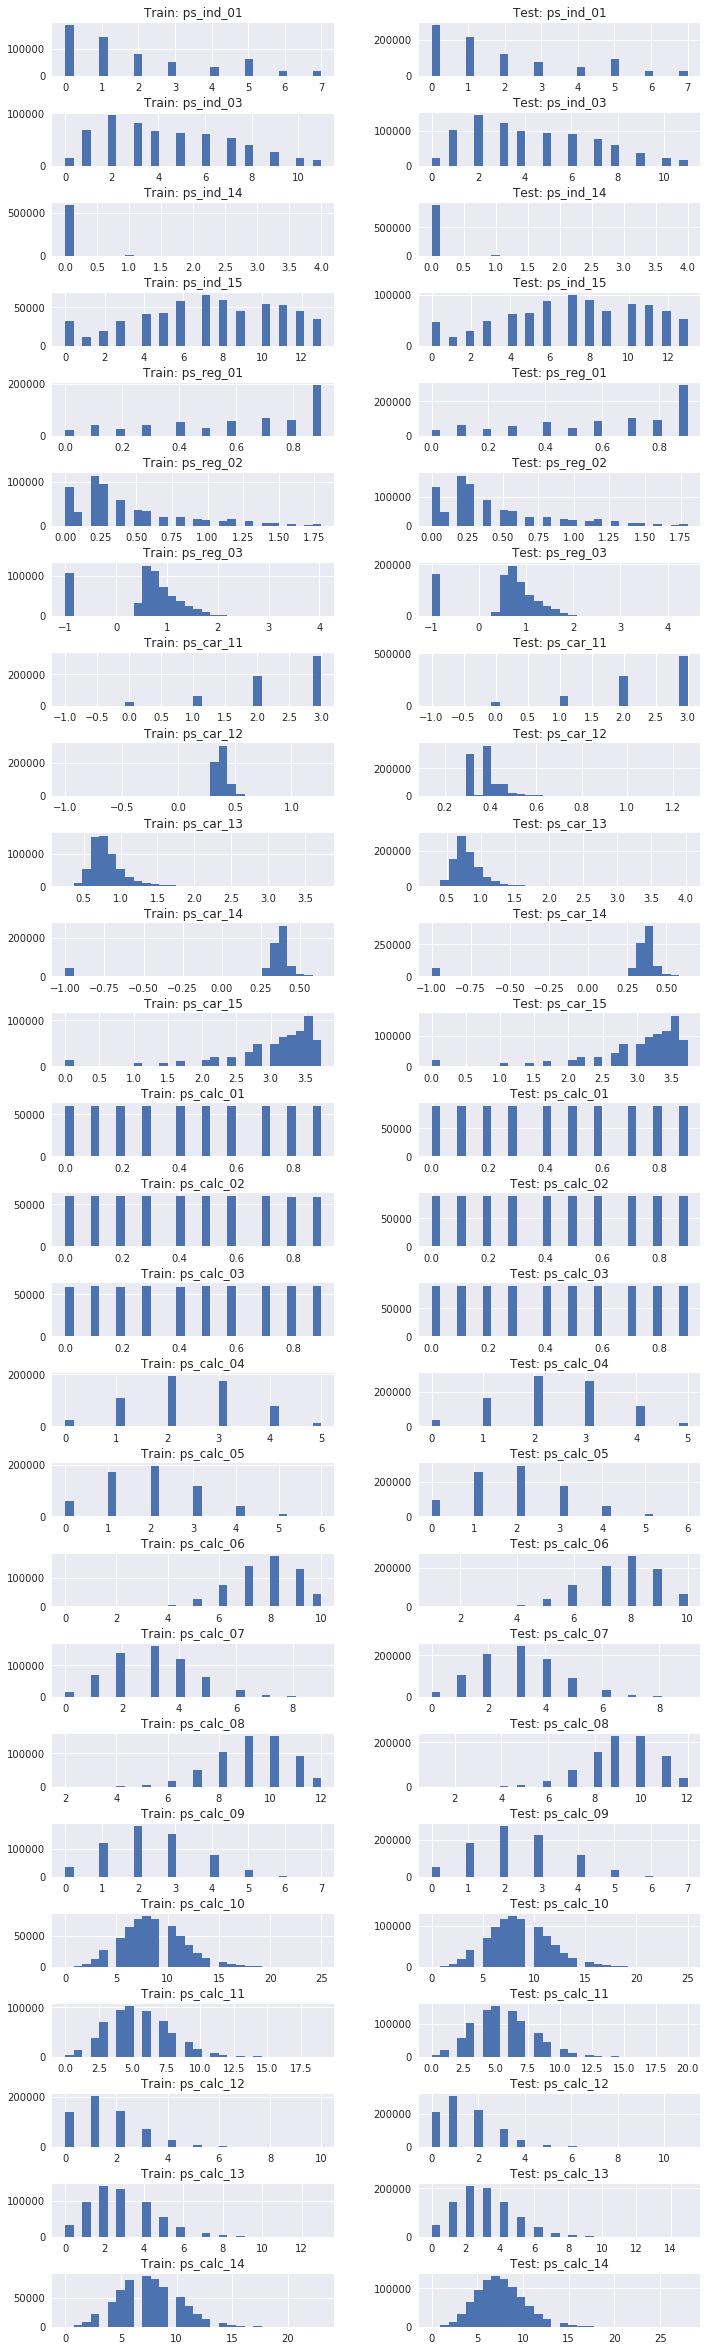

In [17]:
# For etc features
TrainTestHistogram(train, test, feature_list_etc)

With above histogram grid plot, we observed some information.
1. The train and test data have similar distribition in case of binary and categorical data. (Q. Are there other insights from this plots?)
2. Etc feature also have large similarity between train and test set. But, there are somewhat difference between train and test in case of etc.

### I'm beginner of statistics and kaggle. So If you have an idea from these plots, please advise me!! Thanks!

Let's see the etc feature more deelply

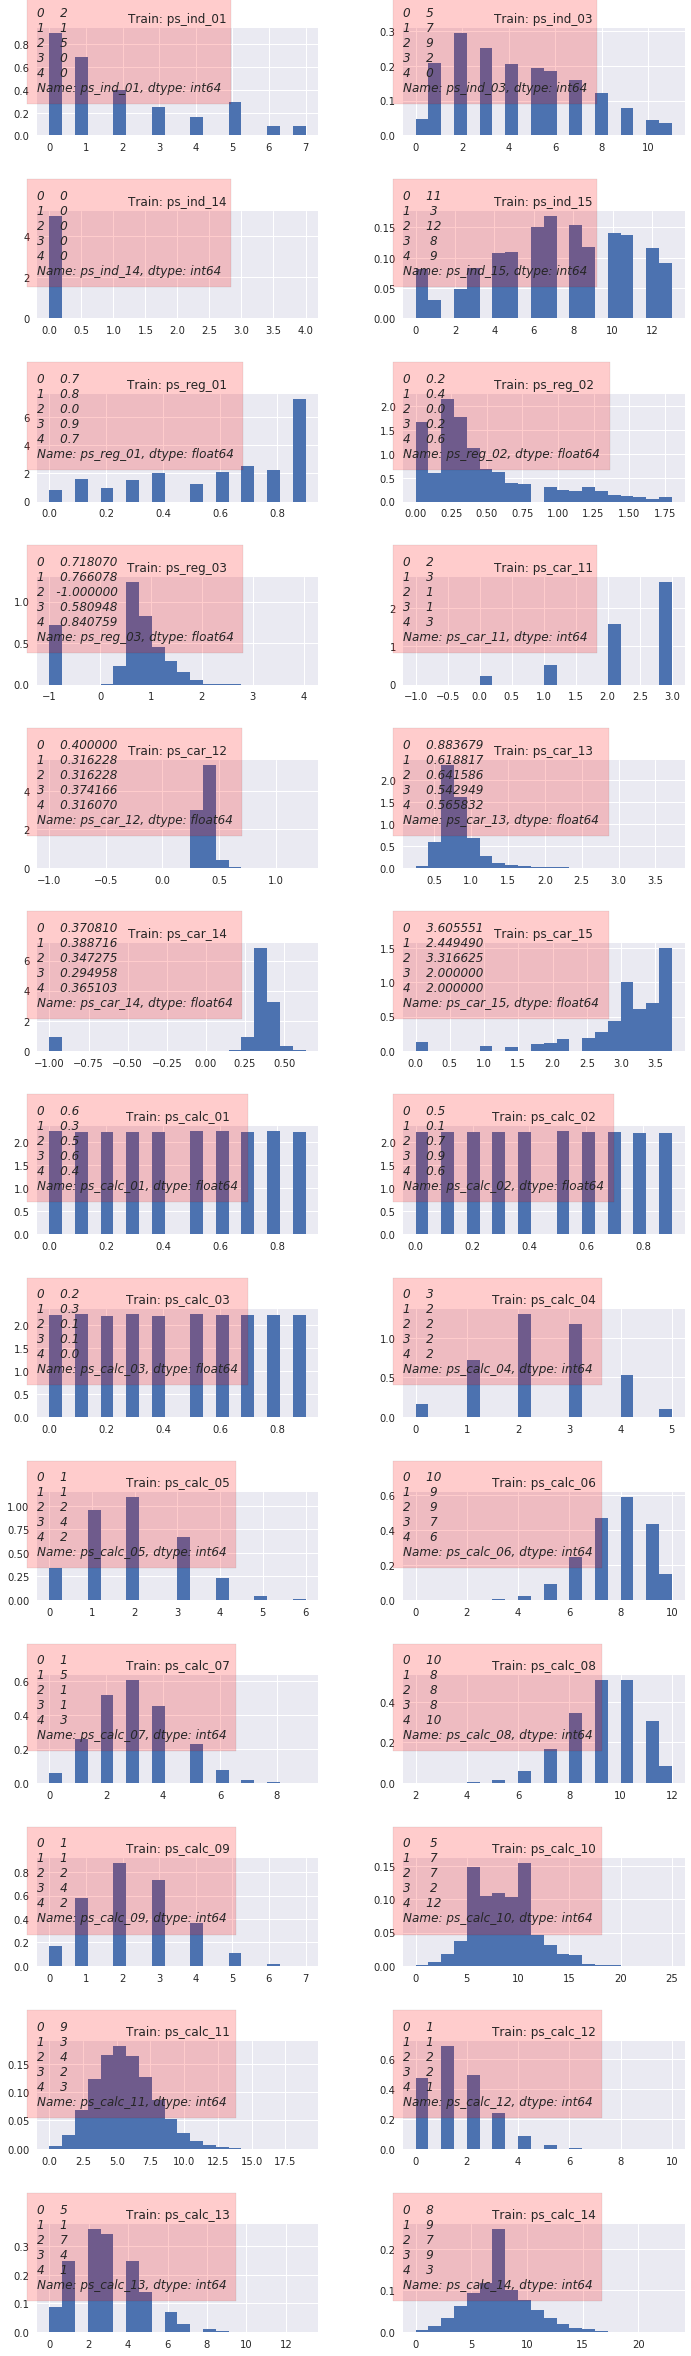

In [18]:
left  = 0  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplot

fig, axes = plt.subplots(13, 2, figsize=(10, 40))
plt.subplots_adjust(left=left, bottom=bottom, right=right, 
                    top=top, wspace=wspace, hspace=hspace)

for i, ax in enumerate(axes.ravel()):
    title = 'Train: ' + feature_list_etc[i]
    ax.hist(train[feature_list_etc[i]], bins=20, normed=True)
    ax.set_title(title)
    ax.text(0, 1.2, train[feature_list_etc[i]].head(), horizontalalignment='left',
            verticalalignment='top', style='italic',
       bbox={'facecolor':'red', 'alpha':0.2, 'pad':10}, transform=ax.transAxes)

Data description said that feature without 'bin' and 'cat' is either ordinal or continuous.
So, simply, these features could be grouped in ordinal and continous group.

### I'm going to analyze this part more deeply
---
Ordinal group
- ps_ind_01
- ps_ind_03
- ps_ind_14
- ps_ind_15
- ps_reg_01
- ps_reg_02
- ps_car_11
- ps_calc_01
- ps_calc_02
- ps_calc_03
- ps_calc_04
- ps_calc_05
- ps_calc_06
- ps_calc_07
- ps_calc_08
- ps_calc_09
- ps_calc_10
- ps_calc_11
- ps_calc_12
- ps_calc_13
- ps_calc_14
---
Continuous group
- ps_reg_03
- ps_car_12
- ps_car_13
- ps_car_14
- ps_car_15


## 2.4 Predict null data based on statistical method
For now, I will change the null data with values obtained from some statistics. I will focus on this part later to get a good result.

In [19]:
# For ordinal group
etc_ordianal_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
                    'ps_reg_02', 'ps_car_11', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
                    'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
                    'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
                    'ps_calc_14']

etc_continuous_features = ['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

train_null_columns = train_null.columns
test_null_columns = test_null.columns

In [20]:
# For train
for feature in train_null_columns:
    if 'cat' in feature or 'bin' in feature:
        # For categorical and binary features with postfix, substitue null values with the most frequent value to avoid float number.
        train_null[feature].fillna(train_null[feature].value_counts().idxmax(), inplace=True)
    elif feature in etc_continuous_features:
        train_null[feature].fillna(train_null[feature].median(), inplace=True)
    elif feature in etc_ordianal_features:
        # For categorical and binary features which was assumed, substitue null values with the most frequent value to avoid float number.
        train_null[feature].fillna(train_null[feature].value_counts().idxmax(), inplace=True)
    else:
        print(feature)

In [21]:
# For test
for feature in test_null_columns:
    if 'cat' in feature or 'bin' in feature:
        # For categorical and binary features with postfix, substitue null values with the most frequent value to avoid float number.
        test_null[feature].fillna(test_null[feature].value_counts().idxmax(), inplace=True)
    elif feature in etc_continuous_features:
        test_null[feature].fillna(test_null[feature].median(), inplace=True)
    elif feature in etc_ordianal_features:
        # For categorical and binary features which was assumed, substitue null values with the most frequent value to avoid float number.
        test_null[feature].fillna(test_null[feature].value_counts().idxmax(), inplace=True)
    else:
        print(feature)

In [22]:
for feature in train_null_columns:
    train[feature] = train_null[feature]
    
for feature in test_null_columns:
    test[feature] = test_null[feature]

Until now, we change all NaN values with some values obtained from simple statistics.

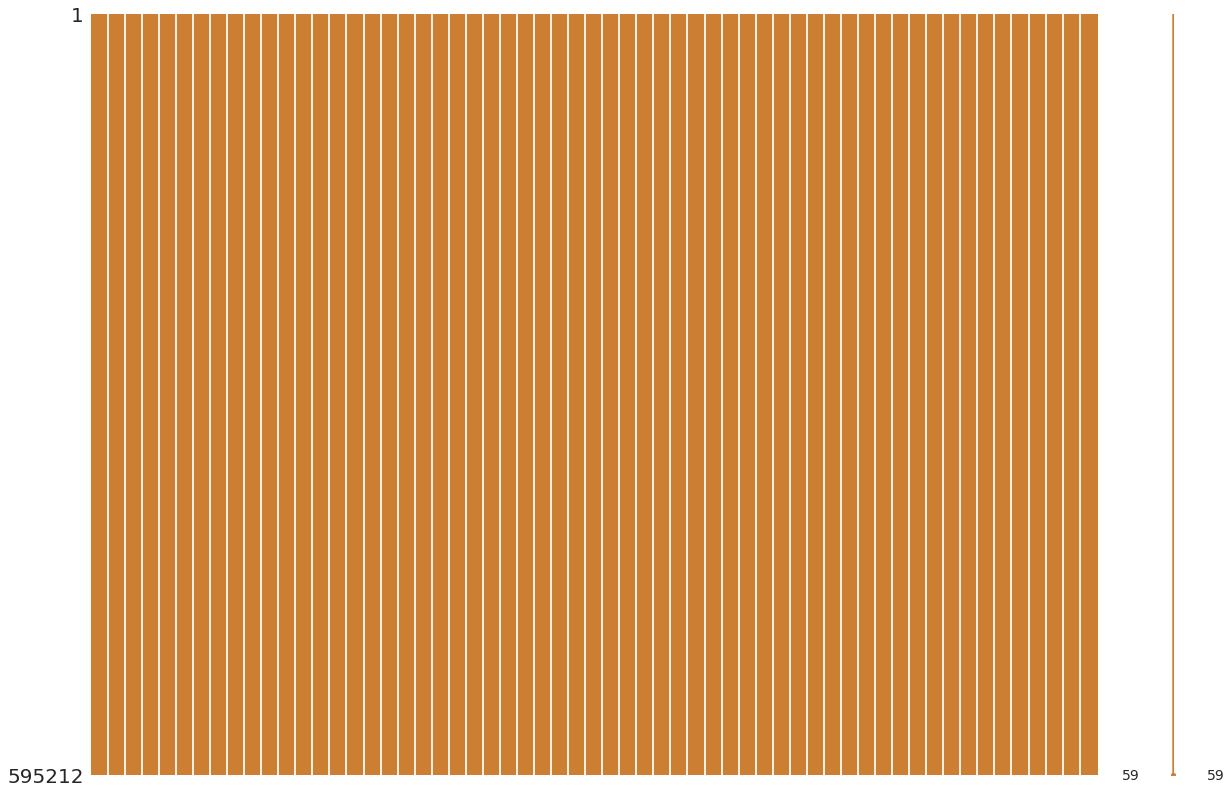

In [23]:
msno.matrix(df=train.iloc[:, :], figsize=(20, 14), color=(0.8, 0.5, 0.2))   

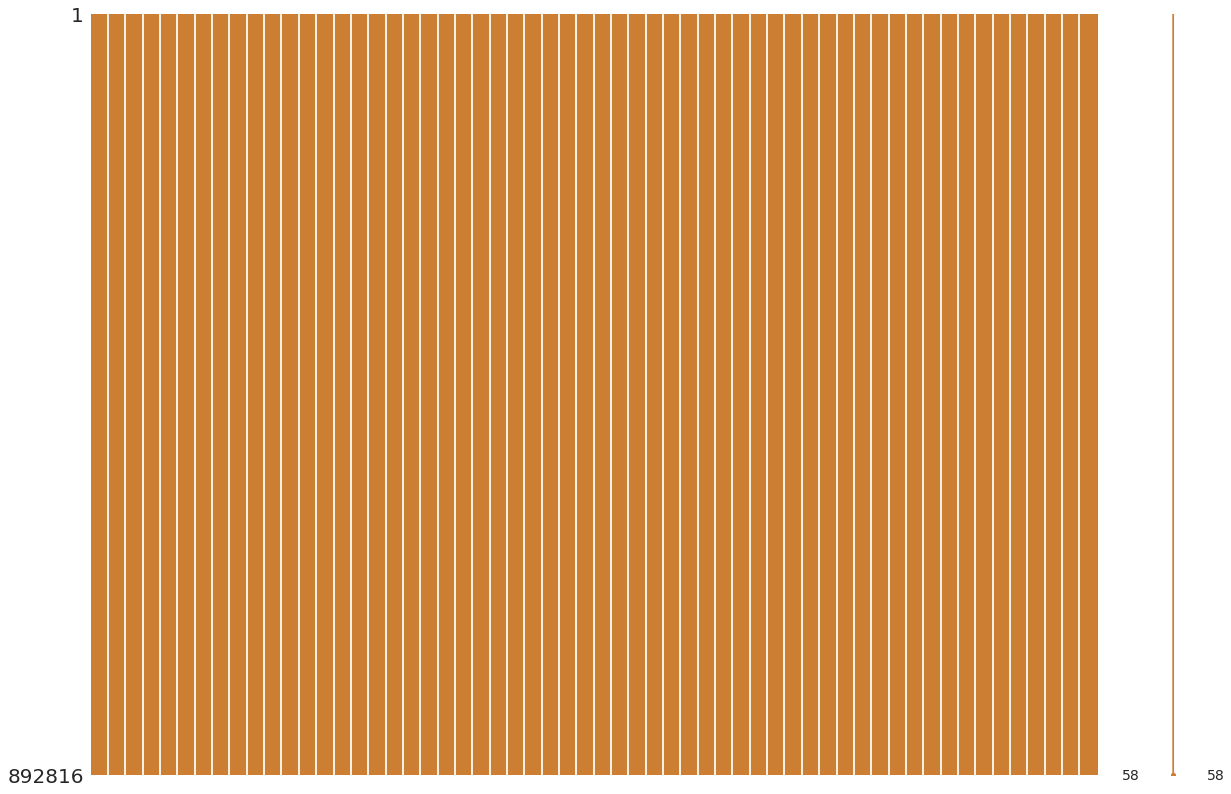

In [24]:
msno.matrix(df=test.iloc[:, :], figsize=(20, 14), color=(0.8, 0.5, 0.2))

As you can see, there is no NaN values in both train and test set.

## 2.5 Onehot encoding for categorical data

For categorical data, I used pd.get_dummy() function to do onehot encoding!

In [25]:
def oneHotEncode_dataframe(df, features):
    for feature in features:
        temp_onehot_encoded = pd.get_dummies(df[feature])
        column_names = ["{}_{}".format(feature, x) for x in temp_onehot_encoded.columns]
        temp_onehot_encoded.columns = column_names
        df = df.drop(feature, axis=1)
        df = pd.concat([df, temp_onehot_encoded], axis=1)
    return df

In [26]:
train = oneHotEncode_dataframe(train, feature_list_cat)
test = oneHotEncode_dataframe(test, feature_list_cat)

# 3. Prediction with xgboost
Let's do the ML and prediction with xgboost!!

In [27]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

## 3.1 Using stratified shuffle split
Stratified shuffle split gives the index set of splited data in train/test sets.
The frequency of each class in each fold have a same ratio with the ration of each class in all dataset.
Detail is [here.](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit)<br>
Applying stratified shuffle split, we can avoid imbalanced sampling problem in case of train and test data split.
Process is explaned below.

1. Choose some classifier. In this case, I chose xgboost.
2. Set the parameter 
-> I think the optimization of parameters would be precede to obtain more good result.
3.  With classifier, do the staratified Shuffle Split.
4. Train at each shuffle split and predict
5. Get a averarage prediction!

In [28]:
n_split = 3
SSS = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=1989)

NameError: name 'StratifiedShuffleSplit' is not defined

In [29]:
# Parameter optimization is needed!
params = {
    'min_child_weight': 10.0,
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
}

In [30]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [31]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [32]:
SSS.get_n_splits(X, y)

NameError: name 'SSS' is not defined

In [33]:
print(SSS)

NameError: name 'SSS' is not defined

In [34]:
for train_index, test_index in SSS.split(X, y):
    print("TRAIN: ", train_index, "TEST: ", test_index)

NameError: name 'SSS' is not defined

Stratified shuffle split returns the index set of splited train and test.
Using this, we can train and predict.

In [35]:
for i, (train_index, test_index) in enumerate(SSS.split(X, y)):
    print('------# {} of {} shuffle split------'.format(i + 1, n_split))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    # Convert splited data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! 
    model = xgb.train(params, d_train, 2000, watchlist, 
                      early_stopping_rounds=100, feval=gini_xgb, maximize=True, verbose_eval=100)

    print('------# {} of {} prediction------'.format(i + 1, n_split))
    # Predict on our test data
    p_test = model.predict(d_test)
    sub['target'] = sub['target'] + p_test/n_split

NameError: name 'SSS' is not defined

In [36]:
# sub.to_csv('stratifiedShuffleSplit_xgboost.csv', index=False)

# 4. Things to do
1. PCA analysis
2. one-hot encoding <br> 
3. Find more deep insight for each features
4. Apply other Algorithms and other technique such as ensemble, etc.

# PS
Making kernel is very helpful to study kaggle and data analysis. <br>
I want to keep improving this kernel. If you want to comment or ask me, feel free. Thanks!